In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
sns.set_context("talk")

# Encoder self-attention

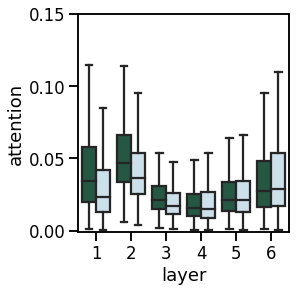

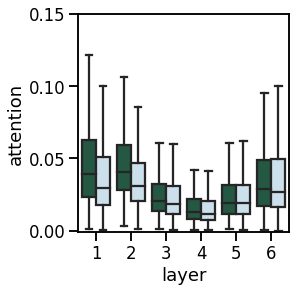

In [3]:
data = pickle.load(open("data/attention.pickle", 'rb'))

for language in ["de", "nl"]:
    # Load data from pickle
    ambiguous = [x for l in range(6) for x in data[(language, "ambiguous")][l]]
    unambiguous = [x for l in range(6) for x in data[(language, "unambiguous")][l]]
    layers = [l for l in range(6) for x in data[(language, "ambiguous")][l]] + \
             [l for l in range(6) for x in data[(language, "unambiguous")][l]]
    hues = ["amb." for _ in ambiguous] + ["other" for _ in unambiguous]

    # Create a boxplot
    colours = sns.color_palette("cubehelix", 6)
    plt.figure(figsize=(4, 4))
    ax = sns.boxplot(x=layers, y=ambiguous + unambiguous,
                     hue=hues, palette=[colours[1], colours[-1]], fliersize=0)

    # Manage labels and ticks put on the axes
    plt.tight_layout()
    ax.set_xlabel("layer")
    ax.set_xticklabels([1, 2, 3, 4, 5, 6])
    ax.set_ylabel("attention")
    plt.legend([], [], frameon=False)
    plt.ylim(-0.001, 0.15)

    # Save to file
    plt.savefig(f"figures/wsd_attention_{language}.pdf", bbox_inches="tight")
    plt.show()

# Encoder-decoder attention

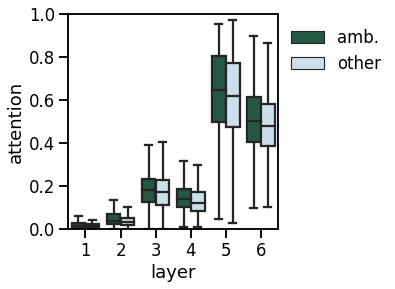

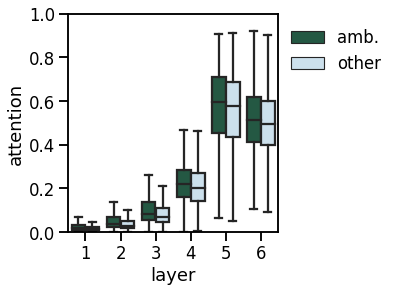

In [4]:
data = pickle.load(open("data/cross_attention.pickle", 'rb'))

for language in ["de", "nl"]:
    # Load data from pickle
    ambiguous = [x for l in range(6) for x in data[(language, "ambiguous")][l]]
    unambiguous = [x for l in range(6) for x in data[(language, "unambiguous")][l]]
    layers = [l for l in range(6) for x in data[(language, "ambiguous")][l]] + \
             [l for l in range(6) for x in data[(language, "unambiguous")][l]]
    hues = ["amb." for _ in ambiguous] + ["other" for _ in unambiguous]

    # Create a boxplot
    colours = sns.color_palette("cubehelix", 6)
    plt.figure(figsize=(4, 4))
    ax = sns.boxplot(x=layers, y=ambiguous + unambiguous,
                     hue=hues, palette=[colours[1], colours[-1]], fliersize=0)

    # Manage labels and ticks put on the axes
    plt.tight_layout()
    ax.set_xlabel("layer")
    ax.set_xticklabels([1, 2, 3, 4, 5, 6])
    ax.set_ylabel("attention")
    plt.legend(bbox_to_anchor=(0.99, 1), frameon=False)
    plt.ylim(-0.001, 1)

    # Save to file
    plt.savefig(f"figures/wsd_cross_attention_{language}.pdf", bbox_inches="tight")
    plt.show()